# TP1 Simulación

## Ejercicio 1

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from statistics import mean, variance

def own_rand():
    own_rand.x_n = (own_rand.x_n * 1013904223 + 1664525) % (2 ** 32)
    return own_rand.x_n
own_rand.x_n = (97811 + 97811 + 97811)/3


In [9]:
result_1a = [own_rand() for i in range(6)]
result_1a

[192755738, 1392371123, 1950649466, 726488403, 2540951770, 1889127667]

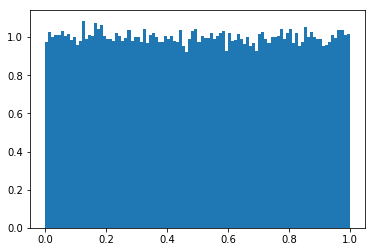

In [10]:
def own_rand_u():
    return float(own_rand())/(2**32)

def rand_u_vector(n):
    return [own_rand_u() for i in range(n)]
result_1b = rand_u_vector(10**5)
plt.hist(result_1b, bins=100, density=True)
plt.show()

## Ejercicio 2

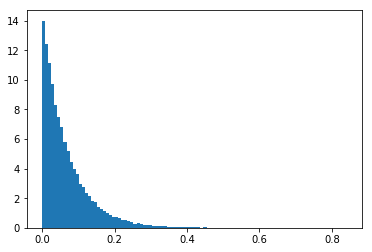

In [7]:
def make_exponential_dist_inverse(lamda):
    def inverse_dist(u):
        return -math.log(u)/lamda
    return inverse_dist

inverse_dist = make_exponential_dist_inverse(15)
inverse_dist = np.vectorize(inverse_dist)

exponential_sample = inverse_dist(rand_u_vector(10**5))

bins_values, bins_edges, _ = plt.hist(exponential_sample,bins=100, density=True)
bins_exp = zip(bins_values, bins_edges[:-1])
plt.show()

In [8]:
mean_exp = mean(exponential_sample)
mode_exp = max(bins_exp, key=(lambda x: x[0]))[1] # Use the first argument as the key to be maxed but return the left edge of the bin which it belongs to
variance_exp = variance(exponential_sample, mean_exp)
mean_exp, mode_exp, variance_exp

(0.06677860080096004, 3.0159397593723117e-07, 0.004490784081843774)

## Ejercicio 3

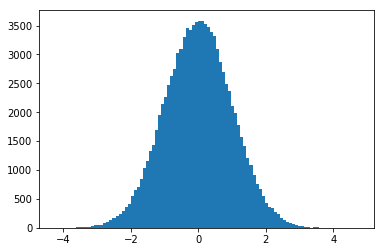

In [9]:
def make_normal_dist_inverse(mu, sigma):
    def inverse_dist(u):
        return norm.ppf(u) * sigma + mu
    return inverse_dist

normal_inverse_dist = make_normal_dist_inverse(0, 1)
normal_inverse_dist = np.vectorize(normal_inverse_dist)
normal_sample = normal_inverse_dist(rand_u_vector(10**5))
bins_values, bins_edges, _ = plt.hist(normal_sample, bins=100)
bins_normal = zip(bins_values, bins_edges[:-1])
plt.show()

***Note: Compared with the expected value(0,0,1), the ones generated are pretty close***

## Ejercicio 4

In [20]:
# def norm_pdf(x, loc, scale):
#    return norm.pdf(x, loc=loc, scale=scale)

#def make_norm_acc_rej(loc=0, scale=1):
#    def norm_acc_rej():
#        start = True
#        while start or y > norm_pdf(x, loc, scale):
#            start = False
#            x = (own_rand() - 0.5) * scale + loc
#            y = own_rand() * norm_pdf(loc, loc, scale)
#        return y
#   return norm_acc_rej

# def norm_acc_rej_vector(qty, loc=0, scale=1):
#     own_acc_rej = make_norm_acc_rej(loc, scale)
#     return [own_acc_rej() for i in range(qty)]

# normal_sample2 = norm_acc_rej_vector(10, 35, 5)

# bins_values, bins_edges, _ = plt.hist(normal_sample2, bins=100, color='#ff000055', density=True)
# bins_normal = zip(bins_values, bins_edges[:-1])

# normal_control_group = [np.random.rand() for i in range(10**5)]
# plt.hist(normal_sample2, bins=100, color='#00ff0055', density=True)
                                    
# plt.show()


# Ejercicio 5



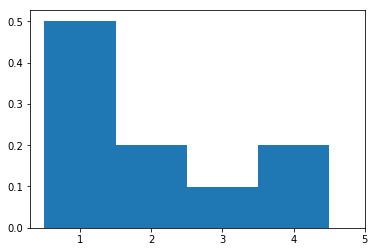

In [41]:
def empiric_inv_distribution(u):
    if u <= 0.5:
        return 1
    elif u <= 0.7:
        return 2
    elif u <= 0.8:
        return 3
    else:
        return 4
    
def gen_empiric():
    return empiric_inv_distribution(own_rand_u())

empiric_sample = [gen_empiric() for i in range(10**5)]


bins_empiric = np.arange(0.5, 5.5, 1)

plt.hist(empiric_sample, bins=bins_empiric, density=True)
plt.xticks(np.arange(1,6,1))
plt.show()

## Ejercicio 6


- Cada lanzamiento de la moneda se puede modelar con una variable aleatoria de distribución Bernoulli. 
- El experimento de lanzar una moneda se puede modelar como una variable aleatoria de distribución Geometrica.


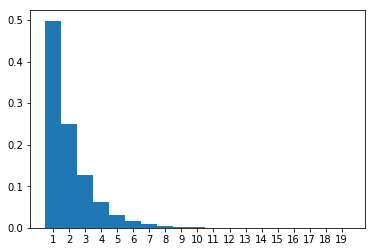

In [42]:
def bernoulli_random():
    return 1 if own_rand_u() < 0.5 else 0

def geometric_random():
    qty = 1
    while bernoulli_random() != 1:
        qty += 1
    return qty

geometric_sample = [geometric_random() for i in range(10**5)]

bins_geometric = np.arange(0.5, 20, 1)

plt.hist(geometric_sample, bins=bins_geometric, density=True)
plt.xticks(np.arange(1,20,1))
plt.show()

## Ejercio 7

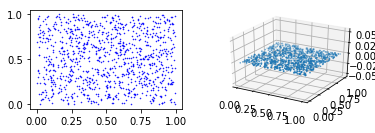

In [68]:
from mpl_toolkits.mplot3d import Axes3D
uniform_random_sample = rand_u_vector(10**3)
uniform_random_sample_x = uniform_random_sample[:-2]
uniform_random_sample_y = uniform_random_sample[1:-1]
uniform_random_sample_z = uniform_random_sample[2:]



plt.subplot(221)
plt.plot(uniform_random_sample_x, uniform_random_sample_y, 'bo', markersize=0.5)

plt.subplot(222, projection='3d')
plt.scatter(uniform_random_sample_x, uniform_random_sample_y, uniform_random_sample_z)
plt.show()

In [69]:
uniform_random_sample_z

[0.9151559681631625,
 0.8246715336572379,
 0.5633476809598505,
 0.7428367182146758,
 0.5977083505131304,
 0.7080147087108344,
 0.1084174201823771,
 0.1700651242863387,
 0.6993262083269656,
 0.8776757090818137,
 0.8629579083062708,
 0.5033623322378844,
 0.3555075884796679,
 0.2684689878951758,
 0.5718421922065318,
 0.5681677951943129,
 0.9205005378462374,
 0.5964589982759207,
 0.19869331875815988,
 0.9711709662806243,
 0.9673031033016741,
 0.3589601933490485,
 0.9258843348361552,
 0.10031129862181842,
 0.287663331720978,
 0.834537026239559,
 0.15453828731551766,
 0.12477824534289539,
 0.8920792699791491,
 0.08300395007245243,
 0.5045282230712473,
 0.9950112595688552,
 0.009798964951187372,
 0.9454254179727286,
 0.8144771889783442,
 0.44269979442469776,
 0.08882046351209283,
 0.04411588306538761,
 0.14175823191180825,
 0.9807833030354232,
 0.7958918125368655,
 0.7826397984754294,
 0.7624943987466395,
 0.9034512385260314,
 0.016511058900505304,
 0.34581161732785404,
 0.17155873635783792,
